In [1]:
#Pyspark essentials
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import col, unix_timestamp, to_date
from pyspark.sql import functions as F
sqlc = SQLContext(sc)

#Plotting essentials
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#Plotting setting
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

sns.set_style("white")
sns.set_palette("muted")


In [2]:
##Read the Consumer Complaint CSV file into df

Complt_df = sqlContext.read.format('csv').options(header='true', inferSchema='true', mode='PERMISSIVE').load("file:///home/cloudera/Consumer_Complaints.csv")
Complt_df.printSchema()


root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: integer (nullable = true)



In [3]:
# Data validation - Check the number of records read in the csv file

Total_Complaints = Complt_df.count()
print(Total_Complaints)

1048575


In [4]:
#Data validation - Check the data type of each coloumn

Complt_df.dtypes

[('Date received', 'string'),
 ('Product', 'string'),
 ('Sub-product', 'string'),
 ('Issue', 'string'),
 ('Sub-issue', 'string'),
 ('Company public response', 'string'),
 ('Company', 'string'),
 ('State', 'string'),
 ('ZIP code', 'string'),
 ('Tags', 'string'),
 ('Consumer consent provided?', 'string'),
 ('Submitted via', 'string'),
 ('Date sent to company', 'string'),
 ('Company response to consumer', 'string'),
 ('Timely response?', 'string'),
 ('Consumer disputed?', 'string'),
 ('Complaint ID', 'int')]

In [5]:
# DATA PREPROCESSINNG

#Change the coloumn names and create a new Dataframe

oldColumns = Complt_df.schema.names
newColumns = ["Date_Rxd", "Product","Sub_Product", "Issue","Sub_Issue","Company_Pub_Resp", "Company", "State",           \
              "Zip_Code","Tags", "Cnsmr_Consent", "Submit_Via", "Date_Sent", "Comp_Resp_Cnsmr", "Timely_Resp","Cnsmr_Disp", \
              "ComplaintID"]

Complaint_df = reduce(lambda Complt_df, idx: Complt_df.withColumnRenamed(oldColumns[idx], newColumns[idx]),         \
                      xrange(len(oldColumns)), Complt_df)


#Bring the date to a uniform formatted string

Complaint_df = Complaint_df.withColumn("Date_Rxd",F.translate(F.col("Date_Rxd"), "-", "/"))
Complaint_df.printSchema()
Complaint_df.show(2)

root
 |-- Date_Rxd: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub_Product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub_Issue: string (nullable = true)
 |-- Company_Pub_Resp: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Cnsmr_Consent: string (nullable = true)
 |-- Submit_Via: string (nullable = true)
 |-- Date_Sent: string (nullable = true)
 |-- Comp_Resp_Cnsmr: string (nullable = true)
 |-- Timely_Resp: string (nullable = true)
 |-- Cnsmr_Disp: string (nullable = true)
 |-- ComplaintID: integer (nullable = true)

+----------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+-----+--------+----+-------------+----------+----------+--------------------+-----------+----------+-----------+
|  Date_Rxd|             Product|     Sub_P

In [6]:
#Register the Dataframe a table and store it in cache

Complaint_df.registerTempTable("Complaint_df")
Complaint_df.cache()


DataFrame[Date_Rxd: string, Product: string, Sub_Product: string, Issue: string, Sub_Issue: string, Company_Pub_Resp: string, Company: string, State: string, Zip_Code: string, Tags: string, Cnsmr_Consent: string, Submit_Via: string, Date_Sent: string, Comp_Resp_Cnsmr: string, Timely_Resp: string, Cnsmr_Disp: string, ComplaintID: int]

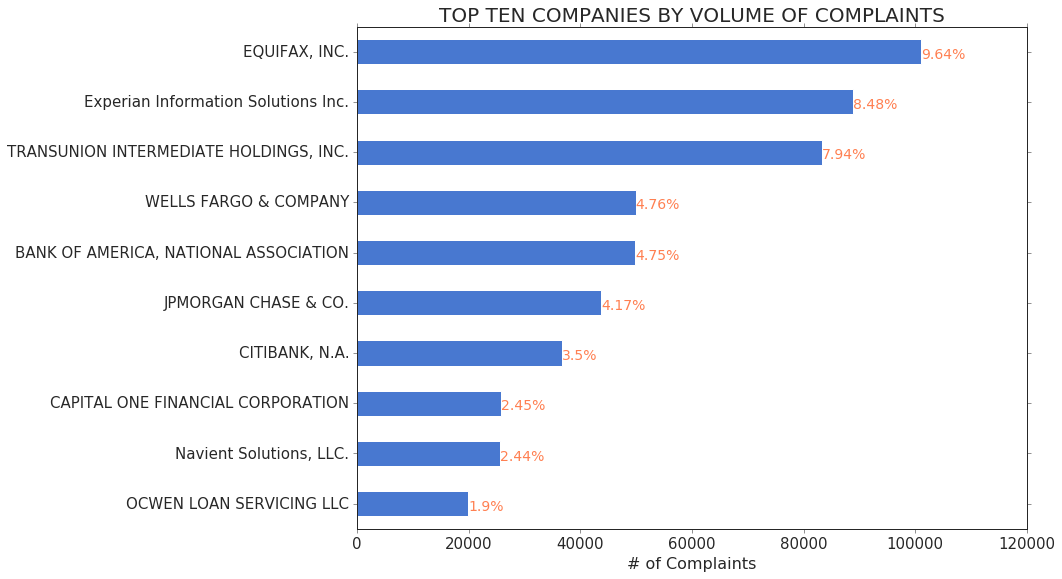

In [7]:
## What are the top 10 companies by the volume of complaints. Indicate the percentage of complaints for 
# each company against the total number of complaints.

TopTenComp = sqlContext.sql("SELECT Company, count(1) AS TotComplaints FROM Complaint_df          \
                            GROUP BY Company                                                      \
                            ORDER BY count(1) DESC LIMIT 10")

plots = TopTenComp.toPandas()

ax=plots.plot(kind='barh',
              x='Company',
              y='TotComplaints',
              legend=None)

plt.title('TOP TEN COMPANIES BY VOLUME OF COMPLAINTS', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 16)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total_Complaints)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()


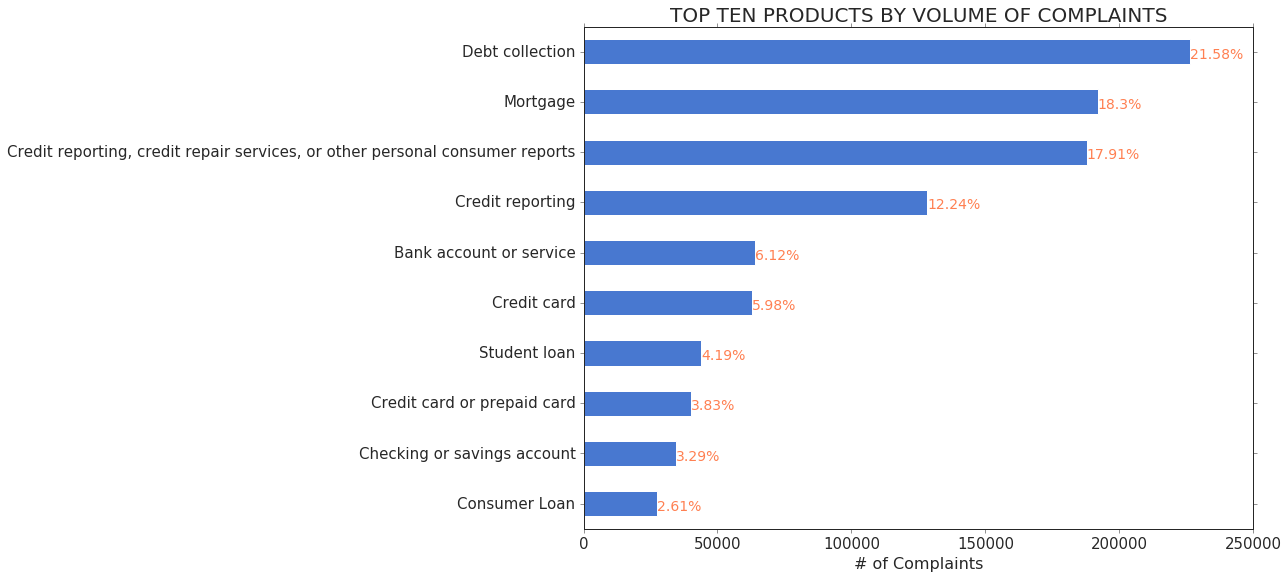

In [8]:
#What are the top 10 products by the volume of complaints. Indicate the percentage of complaints for 
#each product against the total number of complaints.

TopTenProd = sqlContext.sql("SELECT Product, count(1) AS TotComplaints FROM Complaint_df            \
                             GROUP BY Product                                                       \
                             ORDER BY count(1) DESC LIMIT 10")

plots = TopTenProd.toPandas()

ax=plots.plot(kind='barh',
              x='Product',
              y='TotComplaints',
              legend=None)

plt.title('TOP TEN PRODUCTS BY VOLUME OF COMPLAINTS', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 16)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total_Complaints)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()


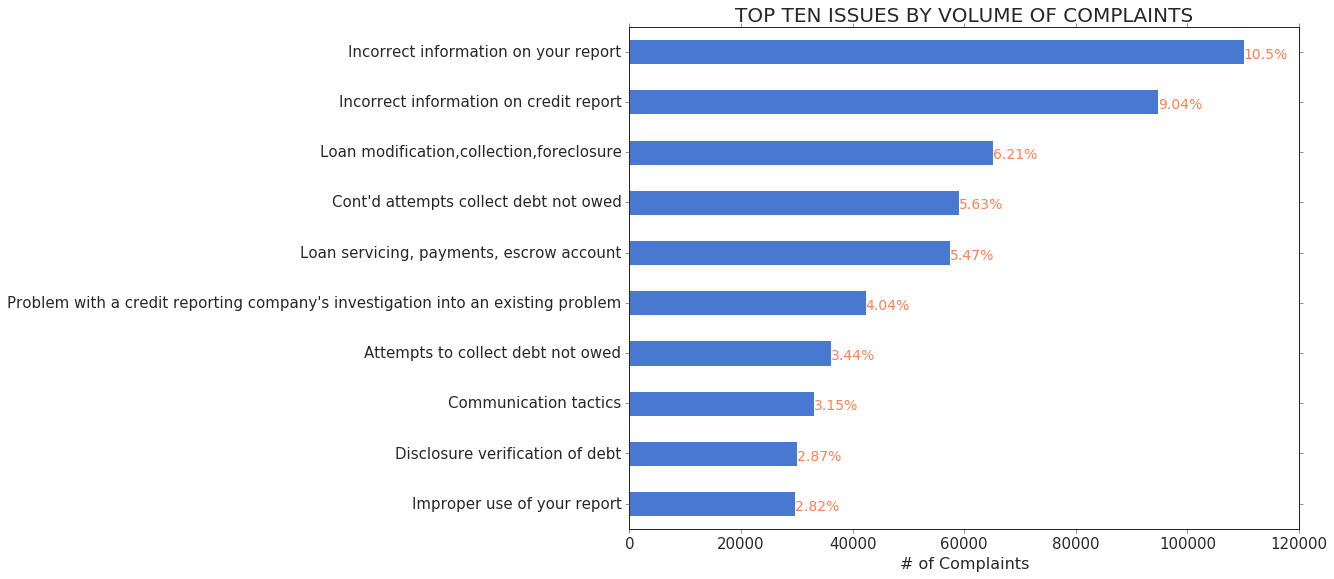

In [9]:
#What are the top 10 issues by the volume of complaints. Indicate the percentage of complaints for each issue
#against the total number of complaints.

TopTenIssue = sqlContext.sql("SELECT Issue, count(1) AS TotComplaints FROM Complaint_df          \
                              GROUP BY Issue                                                     \
                              ORDER BY count(1) DESC LIMIT 10")

plots = TopTenIssue.toPandas()

ax=plots.plot(kind='barh',
              x='Issue',
              y='TotComplaints',
              legend=None)

plt.title('TOP TEN ISSUES BY VOLUME OF COMPLAINTS', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 16)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total_Complaints)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()


/home/cloudera/anaconda2/lib/python2.7/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.6.0 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


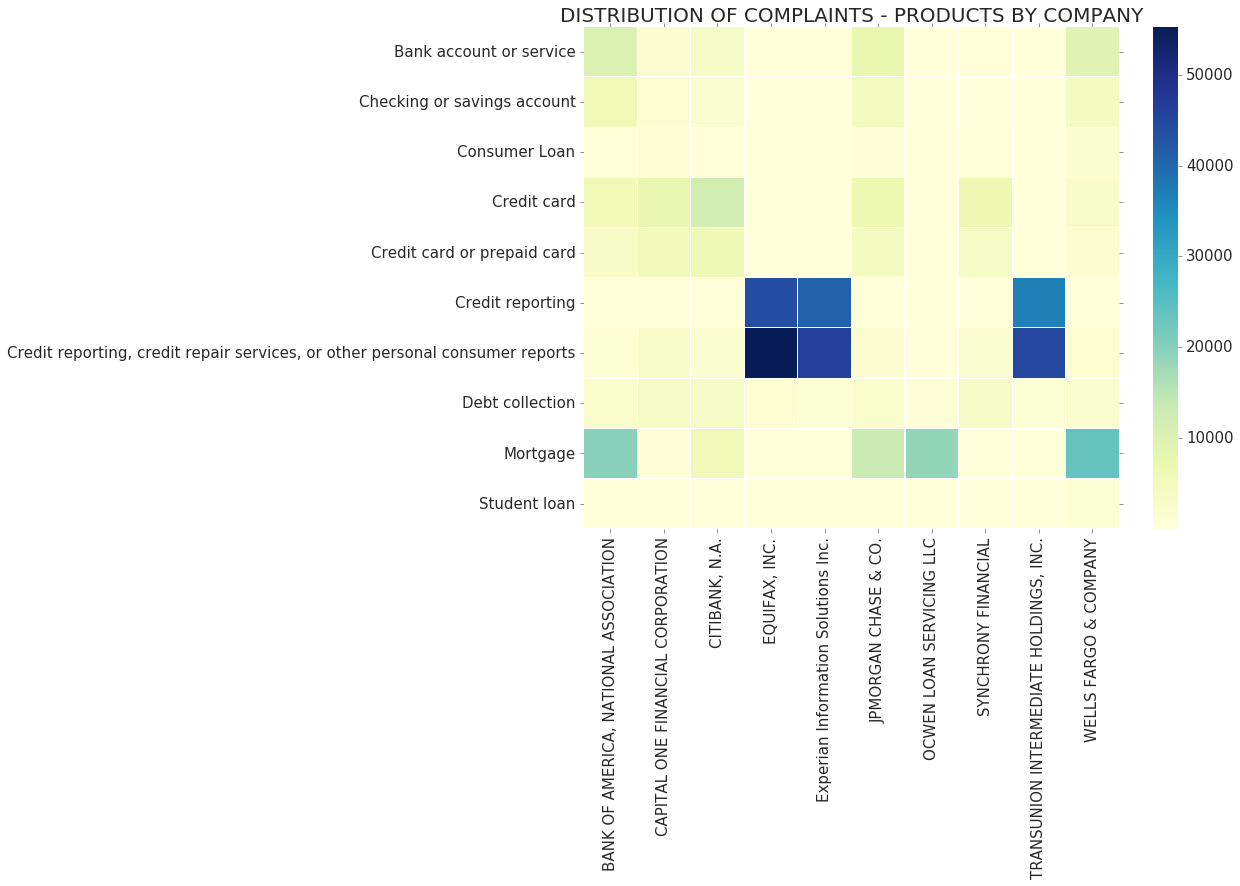

In [10]:
# What is the volume of complaints for the top ten product services provided by the top ten companies.

HeatMap= sqlContext.sql("SELECT Company, Product, count(1) as TotComplaints FROM Complaint_df        \
                         WHERE Company IN                                                            \
                         (SELECT Company FROM Complaint_df                                           \
                         WHERE Company NOT LIKE '%Navient%'                                          \
                         GROUP BY COMPANY ORDER BY count(1) DESC LIMIT 10)                           \
                         AND Product IN                                                              \
                         (SELECT Product FROM Complaint_df                                           \
                         GROUP BY Product ORDER BY count(1) DESC LIMIT 10)                           \
                         GROUP BY Company, Product ORDER BY Company") 

plots = HeatMap.toPandas()

plots = plots.pivot("Product","Company","TotComplaints")
ax = sns.heatmap(plots,linewidths = .1, cmap="YlGnBu")

plt.title('DISTRIBUTION OF COMPLAINTS - PRODUCTS BY COMPANY', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel(' ', fontsize = 16)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

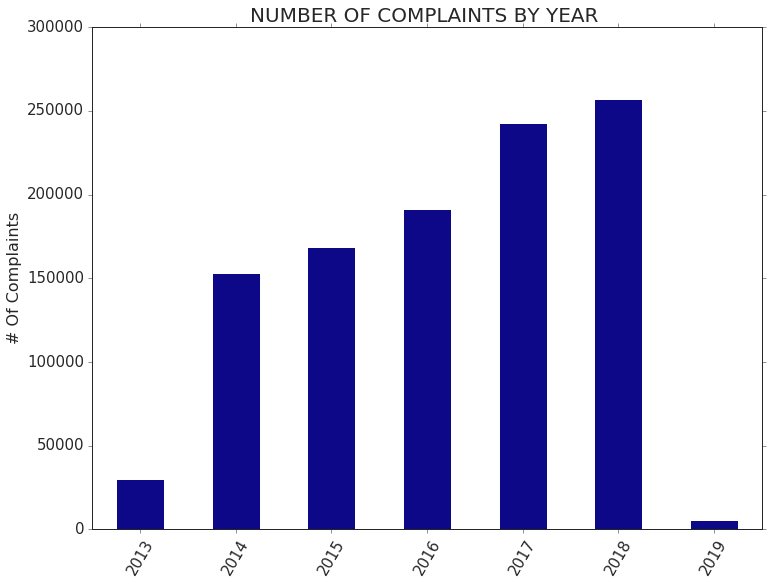

In [11]:
# Has the public database forced companies to take the complaints seriously - What is the distribution of the
# complaints over the period of years?

ComplaintsByYear = sqlContext.sql("SELECT count(1) AS TotComplaints,                                        \
                              year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) AS Year_Rxd FROM Complaint_df GROUP BY Year_Rxd ORDER BY Year_Rxd")
                                  
plots = ComplaintsByYear.toPandas()

plots.plot(kind='bar',
           y='TotComplaints',
           x='Year_Rxd',
           colormap = 'plasma',
           legend=None)

plt.title('NUMBER OF COMPLAINTS BY YEAR ', fontsize=20)
plt.ylabel('# Of Complaints', fontsize = 16)
plt.xlabel(' ', fontsize = 16)
plt.xticks(rotation=60)



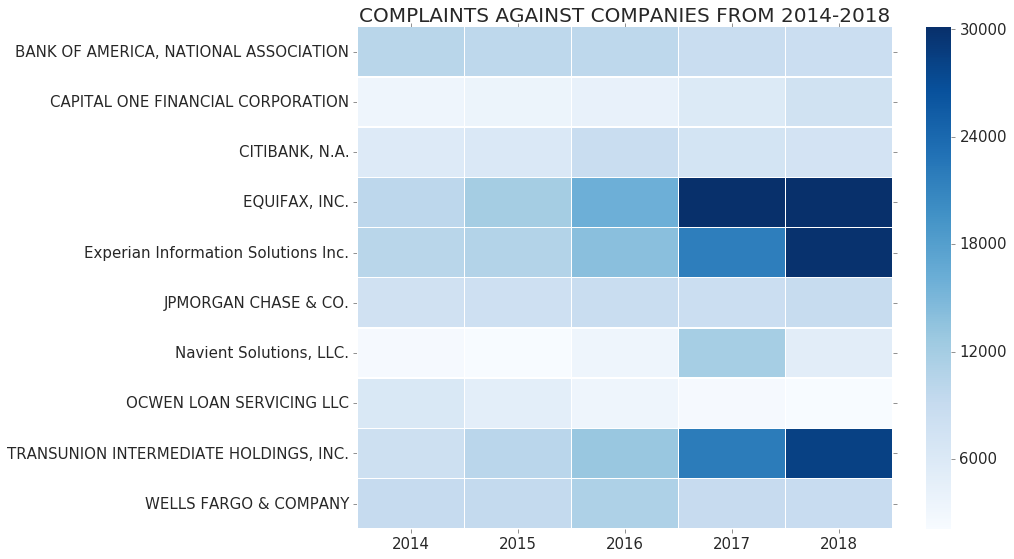

In [12]:
# Has the public database forced companies to take the complaints seriously - Have the number of complaints 
# increased decreased or remained the same for the top ten companies?

HeatMap= sqlContext.sql("SELECT Company,            \
                         year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) AS Year_Rxd,  \
                         count(1) as TotComplaints FROM Complaint_df        \
                         WHERE Company IN (SELECT Company FROM Complaint_df GROUP BY COMPANY ORDER BY count(1) DESC LIMIT 10)  \
                         AND year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) <> 2013   \
                         AND year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) <> 2019   \
                         GROUP BY Company, Year_Rxd ORDER BY Company") 

plots = HeatMap.toPandas()

plots = plots.pivot("Company","Year_Rxd","TotComplaints")
ax = sns.heatmap(plots,linewidths = .5, cmap="Blues",robust=True)

plt.title('COMPLAINTS AGAINST COMPANIES FROM 2014-2018', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel(' ', fontsize = 16)

In [13]:
# Can the database be used to identify bad behaviour?

# Identify the top five companies who do not provide a timely response to the complaints.

# This is calculated as the No Timely Response Rate ie the number of no timely response complaints 
# by the total number of complaints

DF1 = sqlContext.sql("SELECT Company, count(1) AS NoTimeResp                 \
                     FROM Complaint_df                                       \
                     WHERE Timely_Resp = 'No'                                \
                     GROUP BY Company                                        \
                     ORDER BY count(1) DESC")                                \

DF2 = sqlContext.sql("SELECT Company, count(1) AS AllComplaints              \
                     FROM Complaint_df                                       \
                     GROUP BY Company                                        \
                     ORDER BY count(1) DESC")                                \

DF1.registerTempTable("DF1")
DF2.registerTempTable("DF2")

sqlContext.sql("SELECT DF1.Company, (DF1.NoTimeResp/DF2.AllComplaints) AS No_Timely_Resp_Rate  \
               FROM DF1 INNER JOIN DF2 ON DF1.Company = DF2.Company                            \
               ORDER BY No_Timely_Resp_Rate DESC").show(5)    



+--------------------+-------------------+
|             Company|No_Timely_Resp_Rate|
+--------------------+-------------------+
|Medical Services Inc|                1.0|
|Gillman Interests...|                1.0|
|Patriot Lending S...|                1.0|
|     WFI Funding Inc|                1.0|
|Direct Lending Gr...|                1.0|
+--------------------+-------------------+
only showing top 5 rows



+-----------+
|Timely_Resp|
+-----------+
|         No|
|        Yes|
+-----------+



(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

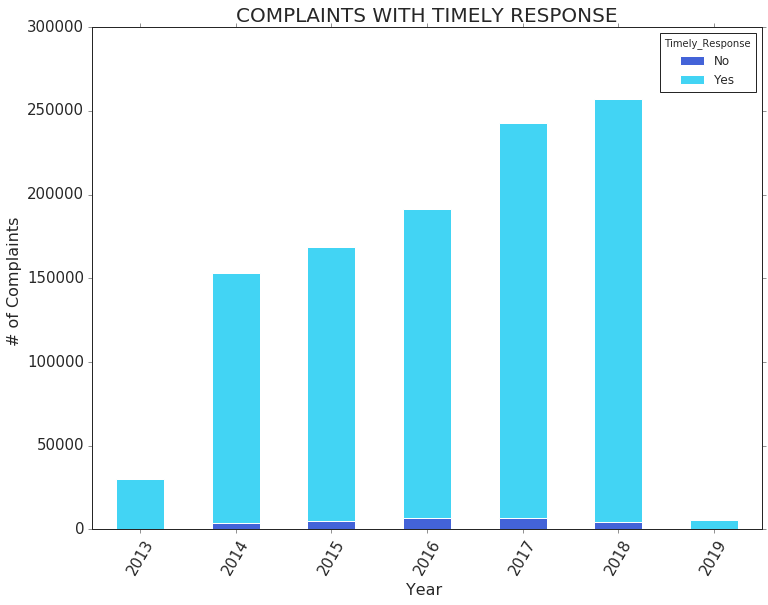

In [14]:
# Has the public database forced companies to take the complaints seriously - Have the number of complaints which were
# given a timely response increased or decreased over the years
 
sqlContext.sql("SELECT distinct Timely_Resp FROM Complaint_df").show()

Time_Response = sqlContext.sql("SELECT Timely_Resp as Timely_Response,             \
                      year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) AS Year_Rxd,    \
                      count(1) AS TotComplaints FROM Complaint_df                  \
                      GROUP BY Timely_Resp, Year_Rxd                               \
                      ORDER BY Timely_Resp, Year_Rxd")
 

plots = Time_Response.toPandas()

plots = plots.pivot("Year_Rxd","Timely_Response","TotComplaints")

colors = ["#4363d8", "#42d4f4", "#3cb44b", "#469990", "#808000", "#96624E", "#bfef45"]
plots.loc[:,['No', 'Yes']].plot.bar(stacked=True, color=colors, figsize=(12,9))

plt.title('COMPLAINTS WITH TIMELY RESPONSE', fontsize=20)
plt.ylabel('# of Complaints ', fontsize = 16)
plt.xlabel('Year ', fontsize = 16)
plt.xticks(rotation=60)



In [15]:
#Identify the top five companies where the customer has disputed the resolution provided by the company.

#Dispute Rate is calculated as the total number of disputed statements / total number of complaints

DF1 = sqlContext.sql("SELECT Company, count(1) AS DispCnt FROM Complaint_df WHERE Cnsmr_Disp = 'Yes' GROUP BY Company ORDER BY count(1) DESC")

DF2 = sqlContext.sql("SELECT Company, count(1) AS AllCompl FROM Complaint_df                   \
                      GROUP BY Company ORDER BY count(1) DESC")

DF1.registerTempTable("DF1")
DF2.registerTempTable("DF2")

sqlContext.sql("SELECT DF1.Company, (DF1.DispCnt/DF2.AllCompl) AS Dispute_Rate FROM DF1 INNER JOIN DF2 ON DF1.Company = DF2.Company ORDER BY Dispute_Rate DESC").show(5)


+--------------------+------------+
|             Company|Dispute_Rate|
+--------------------+------------+
|Midwest Bankers M...|         1.0|
|FIRST AMERICAN UC...|         1.0|
|    HJ Ventures, LLC|         1.0|
|Asset One Mortgag...|         1.0|
|M H Loans Corpora...|         1.0|
+--------------------+------------+
only showing top 5 rows



+----------+
|Cnsmr_Disp|
+----------+
|        No|
|       N/A|
|       Yes|
+----------+



(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

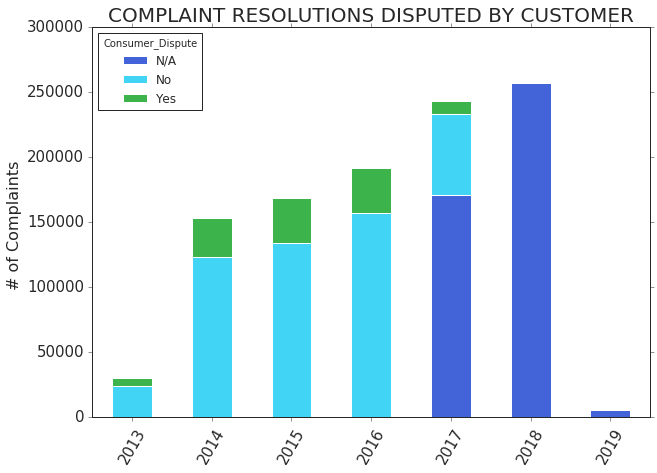

In [16]:
# Has the public database forced companies to take the complaints seriously - How many customers have 
# received a good resolution which has not been disputed by them
 
sqlContext.sql("SELECT distinct Cnsmr_Disp FROM Complaint_df").show()

Consumer_Dispute = sqlContext.sql("SELECT Cnsmr_Disp AS Consumer_Dispute,           \
                      year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) AS Year_Rxd,    \
                      count(1) AS TotComplaints FROM Complaint_df                    \
                      GROUP BY Cnsmr_Disp, Year_Rxd                                  \
                      ORDER BY Cnsmr_Disp, Year_Rxd")

plots = Consumer_Dispute.toPandas()

plots = plots.pivot("Year_Rxd","Consumer_Dispute","TotComplaints")

plots.loc[:,['N/A','No', 'Yes']].plot.bar(stacked=True, color=colors, figsize=(10,7))

plt.title('COMPLAINT RESOLUTIONS DISPUTED BY CUSTOMER', fontsize=20)
plt.ylabel('# of Complaints ', fontsize = 16)
plt.xlabel(' ', fontsize = 16)
plt.xticks(rotation=60)


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

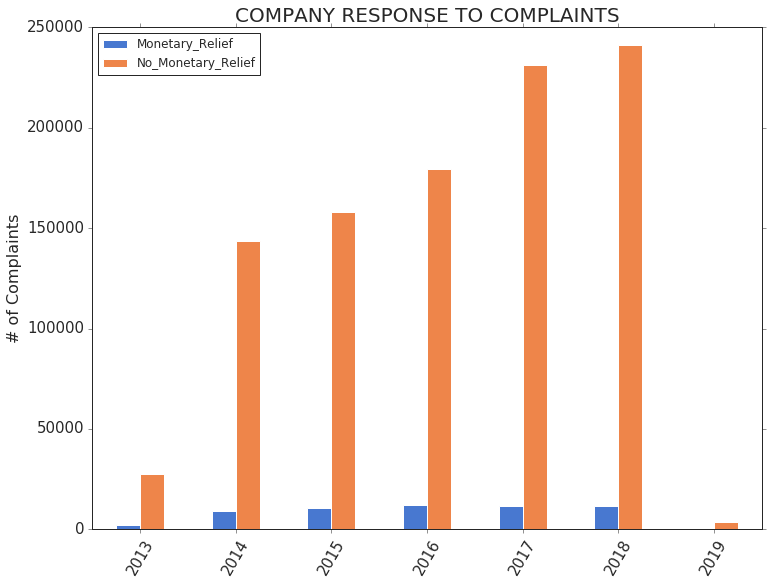

In [17]:
# Are the complaints misinterpreted or misunderstood. Of the complaints that were filed by the customers, how many worked
# in the favour of the customer ie they received monetary relief.

df=sqlContext.sql("SELECT distinct Comp_Resp_Cnsmr FROM Complaint_df")
df.head(10)

Company_Response_Money = sqlContext.sql("SELECT year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) AS Year_Rxd,    \
                      count(1) AS Monetary_Relief FROM Complaint_df                    \
                      WHERE Comp_Resp_Cnsmr = 'Closed with monetary relief'            \
                      GROUP BY Year_Rxd                                                                            \
                      ORDER BY Year_Rxd")

Df1 = Company_Response_Money.toPandas()

Company_Response_NoMoney = sqlContext.sql("SELECT year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) AS Year_Rxd,    \
                      count(1) AS No_Monetary_Relief FROM Complaint_df                                             \
                      WHERE Comp_Resp_Cnsmr IN ('Untimely response','Closed with non-monetary relief','Closed with explanation','Closed')                                        \
                      GROUP BY Year_Rxd                                                                             \
                      ORDER BY Year_Rxd")

Df2 = Company_Response_NoMoney.toPandas()

plots = pd.merge(Df1, Df2, how='inner')

plots.plot(kind='bar',
           y=['Monetary_Relief','No_Monetary_Relief'],
           x='Year_Rxd')
           
plt.title('COMPANY RESPONSE TO COMPLAINTS', fontsize=20)
plt.ylabel('# of Complaints', fontsize = 16)
plt.xlabel(' ', fontsize = 16)
plt.xticks(rotation=60)



In [18]:
# Are the complaints misinterpreted or misunderstood. Of the complaints that were filed by the customers, 
# how many were misinterpreted or misunderstood as listed in the company's public response

CompPubResp = sqlContext.sql("SELECT Company_Pub_Resp, count(1) AS TotComplaints from Complaint_df             \
                             WHERE Company_Pub_Resp <> ' '                                    \
                             GROUP BY Company_Pub_Resp ORDER BY count(1) DESC")

pd.set_option('display.max_colwidth', -1)

plots = CompPubResp.toPandas()
plots.head(20)



,Company_Pub_Resp,TotComplaints
0,Company has responded to the consumer and the CFPB and chooses not to provide a public response,276713
1,Company believes it acted appropriately as authorized by contract or law,56960
2,Company chooses not to provide a public response,52472
3,Company believes the complaint is the result of a misunderstanding,5318
4,Company disputes the facts presented in the complaint,4961
5,Company believes complaint caused principally by actions of third party outside the control or direction of the company,3800
6,Company believes complaint is the result of an isolated error,3509
7,Company believes complaint represents an opportunity for improvement to better serve consumers,2408
8,Company can't verify or dispute the facts in the complaint,2213
9,Company believes complaint relates to a discontinued policy or procedure,61


+-----------+-------------+
| Submit_Via|TotComplaints|
+-----------+-------------+
|        Web|       801698|
|   Referral|       116693|
|      Phone|        58731|
|Postal mail|        55541|
|        Fax|        15831|
|      Email|           81|
+-----------+-------------+



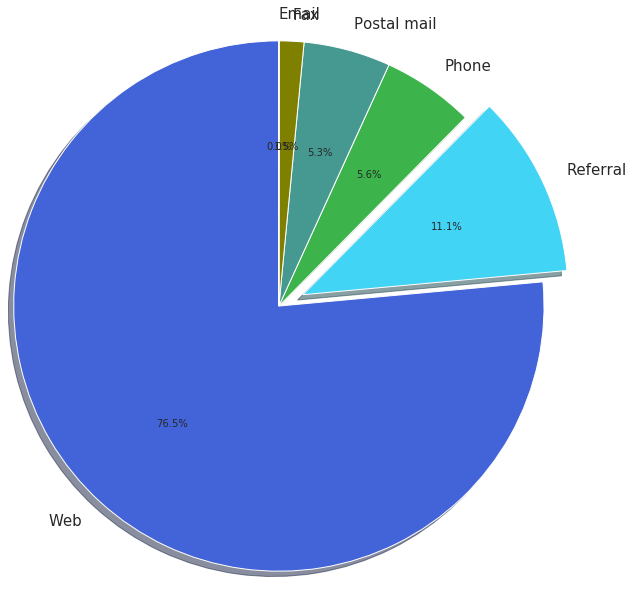

In [19]:
# What is the most popular method to submit the complaints


Sub_Mode = sqlContext.sql("SELECT Submit_Via, count(1) as TotComplaints FROM Complaint_df                                   \
                          GROUP BY Submit_Via                                                                   \
                          ORDER BY count(1) DESC")
Sub_Mode.show(10)

plots = Sub_Mode.toPandas()
fig = plt.figure(figsize=(8,8))
explode = (0, 0.1, 0, 0, 0, 0) 

plt.pie(
    plots['TotComplaints'],
    labels=plots['Submit_Via'],
    explode=explode,
    shadow=True,
    colors=colors,
    startangle=90,
    autopct='%1.1f%%'
    )

plt.axis('equal')
plt.tight_layout()
plt.show()

In [20]:
#What are the top five and bottom five states by the volume of the complaints?

print("Top five states by volume of complaints")
sqlContext.sql("SELECT State, count(1) AS Complaints FROM Complaint_df      \
                GROUP BY State ORDER BY count(1) DESC").show(5)

print(' ')
print("Bottom five states by volume of complaints")
sqlContext.sql("SELECT State, count(1) AS Complaints FROM Complaint_df      \
               GROUP BY State ORDER BY count(1)").show(5)


Top five states by volume of complaints
+-----+----------+
|State|Complaints|
+-----+----------+
|   CA|    141281|
|   FL|    101313|
|   TX|     91543|
|   NY|     69703|
|   GA|     55139|
+-----+----------+
only showing top 5 rows

 
Bottom five states by volume of complaints
+--------------------+----------+
|               State|Complaints|
+--------------------+----------+
|                  PW|         9|
|                  AA|        21|
|                  AS|        22|
|                  MH|        23|
|UNITED STATES MIN...|        26|
+--------------------+----------+
only showing top 5 rows



In [21]:
#Identify the top five companies with the most complaints for the product with the least number of complaints.

sqlContext.sql("SELECT Product, Company, count(1) AS Complaints FROM Complaint_df               \
                WHERE Product IN                                                                \
               (SELECT Product FROM Complaint_df GROUP BY Product ORDER BY count(1) LIMIT 1) GROUP BY Product, Company ORDER BY Complaints DESC").show(5)


+----------------+--------------------+----------+
|         Product|             Company|Complaints|
+----------------+--------------------+----------+
|Virtual currency|      Coinbase, Inc.|        15|
|Virtual currency|Circle Internet F...|         3|
+----------------+--------------------+----------+



In [22]:
#Identify the top five companies with the most complaints for the product with maximum number of complaints.

sqlContext.sql("SELECT Product, Company, count(1) AS Complaints FROM Complaint_df          \
                WHERE Product IN                                                           \
               (SELECT Product FROM Complaint_df GROUP BY Product ORDER BY count(1) DESC LIMIT 1) GROUP BY Product, Company ORDER BY Complaints DESC").show(5)


+---------------+--------------------+----------+
|        Product|             Company|Complaints|
+---------------+--------------------+----------+
|Debt collection|ENCORE CAPITAL GR...|      9730|
|Debt collection|PORTFOLIO RECOVER...|      8582|
|Debt collection|                 ERC|      5777|
|Debt collection|      CITIBANK, N.A.|      3847|
|Debt collection| SYNCHRONY FINANCIAL|      3738|
+---------------+--------------------+----------+
only showing top 5 rows



(array([735234., 735599., 735964., 736330., 736695., 737060.]),
 <a list of 6 Text xticklabel objects>)

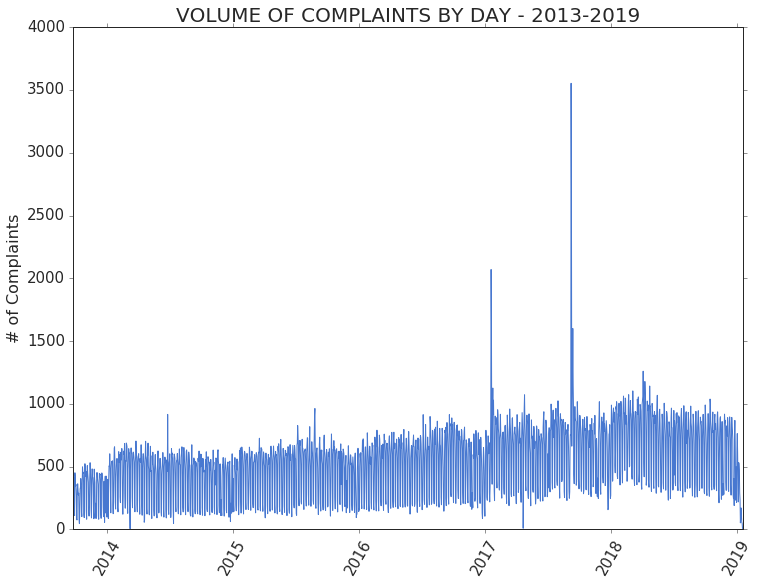

In [23]:
# EQUIFAX DATA BREACH

# Can the complaint database be used to highlight a services breakdown for companies?

# Let us first look at the complaint distribution for the past 6 years and identify any spurts 
# in number of complaints

ComplsOvTime = sqlContext.sql("SELECT count(1) AS TotComplaints, date(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))    \
                               AS Date_Rxd FROM Complaint_df                \
                               GROUP BY Date_Rxd ORDER BY Date_Rxd")
plots = ComplsOvTime.toPandas()

ax =plots.plot(kind='line',
               y='TotComplaints',
               x='Date_Rxd',
               legend=None)

plt.title('VOLUME OF COMPLAINTS BY DAY - 2013-2019', fontsize=20)
plt.ylabel('# of Complaints', fontsize = 16)
plt.xlabel(' ', fontsize = 16)
plt.xticks(rotation=60)


(array([736330., 736361., 736389., 736420., 736450., 736481., 736511.,
        736542., 736573., 736603., 736634., 736664.]),
 <a list of 12 Text xticklabel objects>)

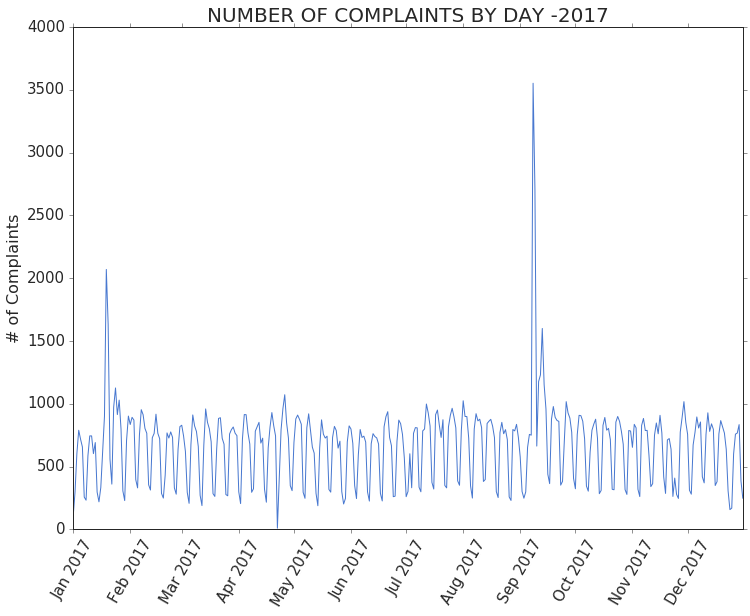

In [24]:
# Let us now look at the complaint distribution in 2017 and identify any spurts in number of complaints


ComplsIn2017 = sqlContext.sql("SELECT count(1) AS TotComplaints, date(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))    \
                               AS Date_Rxd FROM Complaint_df                      \
                               WHERE year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) = 2017    \
                               GROUP BY Date_Rxd ORDER BY Date_Rxd")
plots = ComplsIn2017.toPandas()

ax =plots.plot(kind='line',
               y='TotComplaints',
               x='Date_Rxd',
               legend=None)

plt.title('NUMBER OF COMPLAINTS BY DAY -2017', fontsize=20)
plt.ylabel('# of Complaints', fontsize = 16)
plt.xlabel(' ', fontsize = 16)
plt.xticks(rotation=60)

# So we know something happened in January and September 2017. Let us further explore the September 2017 data.

(array([736574., 736577., 736580., 736583., 736586., 736589., 736592.,
        736595., 736598., 736601.]), <a list of 10 Text xticklabel objects>)

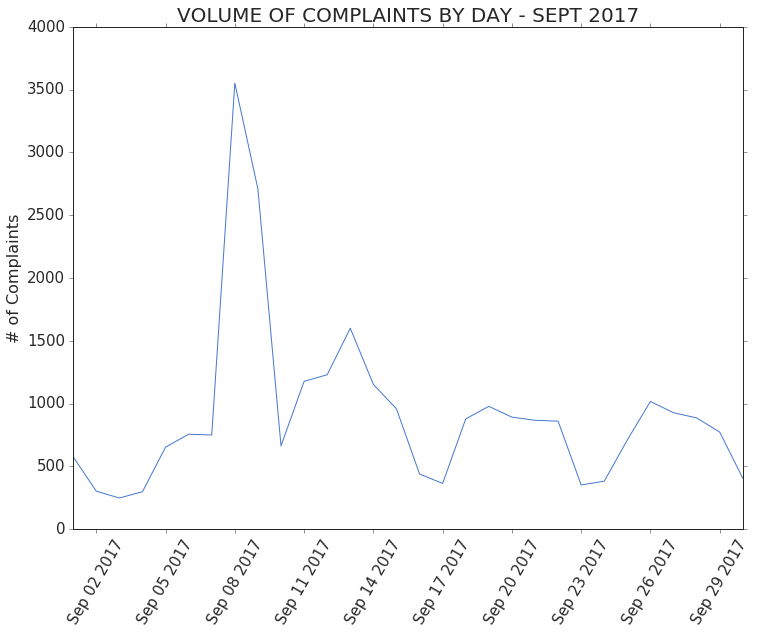

In [25]:
# Let us now look at the complaint distribution in September2017 and identify any spurts in number of complaints


ComplsInSep2017 = sqlContext.sql("SELECT count(1) AS TotComplaints, date(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))    \
                               AS Date_Rxd FROM Complaint_df                      \
                               WHERE year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) = 2017    \
                               AND month(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))  = 9       \
                               GROUP BY Date_Rxd ORDER BY Date_Rxd")
plots = ComplsInSep2017.toPandas()

ax =plots.plot(kind='line',
               y='TotComplaints',
               x='Date_Rxd',
               legend=None)

plt.title('VOLUME OF COMPLAINTS BY DAY - SEPT 2017', fontsize=20)
plt.ylabel('# of Complaints', fontsize = 16)
plt.xlabel(' ', fontsize = 16)
plt.xticks(rotation=60)



In [26]:
# Let us create a separate dataframe for the complaints in September 2017

ComplsInSep2017 = sqlContext.sql("SELECT Date_Rxd, Product, Sub_Product, Issue, Sub_Issue,     \
                                  Company_Pub_Resp, Company, State, Zip_Code, Cnsmr_Consent    \
                                  Submit_Via, Date_Sent, Comp_Resp_Cnsmr, Timely_Resp, Cnsmr_Disp  \
                                  FROM Complaint_df                      \
                               WHERE year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) = 2017    \
                               AND month(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))  = 9")
plots = ComplsInSep2017.toPandas()

Total_Complaints_Sep2017 = ComplsInSep2017.count()
print(Total_Complaints_Sep2017)

#Register the Dataframe a table and store it in cache
ComplsInSep2017.registerTempTable("ComplsInSep2017")
ComplsInSep2017.cache()
#

27357


DataFrame[Date_Rxd: string, Product: string, Sub_Product: string, Issue: string, Sub_Issue: string, Company_Pub_Resp: string, Company: string, State: string, Zip_Code: string, Submit_Via: string, Date_Sent: string, Comp_Resp_Cnsmr: string, Timely_Resp: string, Cnsmr_Disp: string]

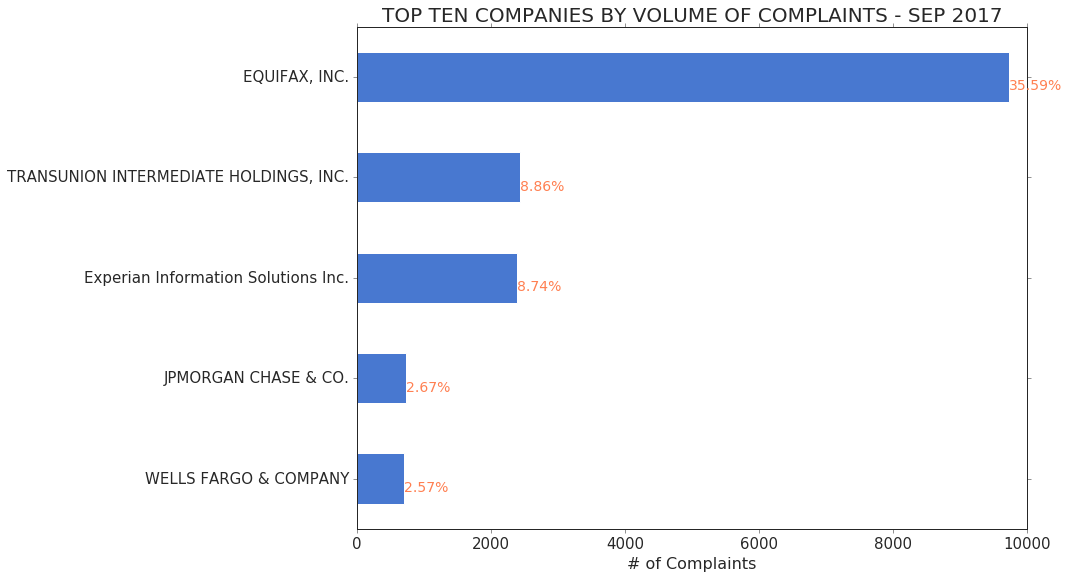

In [27]:
#In September 2017, which companies had the most complaints? 

TopFiveComp = sqlContext.sql("SELECT Company, count(1) AS TotComplaints FROM ComplsInSep2017            \
                            GROUP BY Company                                                            \
                            ORDER BY count(1) DESC LIMIT 5")

plots = TopFiveComp.toPandas()

ax=plots.plot(kind='barh',
              x='Company',
              y='TotComplaints',
              legend=None)

plt.title('TOP TEN COMPANIES BY VOLUME OF COMPLAINTS - SEP 2017', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 16)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total_Complaints_Sep2017)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()


In [36]:
# What is the total number of complaints against Equifax Inc in September 2017?
Equifax_SepCnt = sqlContext.sql("SELECT Company, count(1) AS TotComplaints_Sep2017 FROM ComplsInSep2017                  \
                            WHERE Company LIKE 'EQUIFAX%'                                       \
                            GROUP BY Company                                                    \
                            ORDER BY count(1) DESC LIMIT 5")
DF1 = Equifax_SepCnt.toPandas()


# WHat is the total number of complaints against Equifax Inc in the database except for the month Sep 2017
Equifax_AllExcpSepCnt = sqlContext.sql("SELECT Company, count(1) AS TotComplaints_ExcptSep2017 FROM Complaint_df                     \
                            WHERE Company LIKE 'EQUIFAX%'                                       \
                            AND year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) <> 2017    \
                            AND month(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))  <> 9     \
                            GROUP BY Company                                                    \
                            ORDER BY count(1) DESC LIMIT 5")
DF2 = Equifax_AllExcpSepCnt.toPandas()

# Count the number of year-month combinations in the consumer database
MMYY_Count = sqlContext.sql("SELECT distinct(year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)),   \
                       month(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))) AS Instances           \
                       FROM Complaint_df ORDER BY Instances")
Count = MMYY_Count.count()


# WHat is the average number of complaints against Equifax Inc per month in the database
DF2['TotComplaints_Sep2017'] = DF1['TotComplaints_Sep2017']                                                                           
DF2['MonthAvg_ExclSep2017'] = DF2['TotComplaints_ExcptSep2017'] / (Count-1)  
DF2.head()

,Company,TotComplaints_ExcptSep2017,TotComplaints_Sep2017,MonthAvg_ExclSep2017
0,"EQUIFAX, INC.",64581,9736,1009.078125


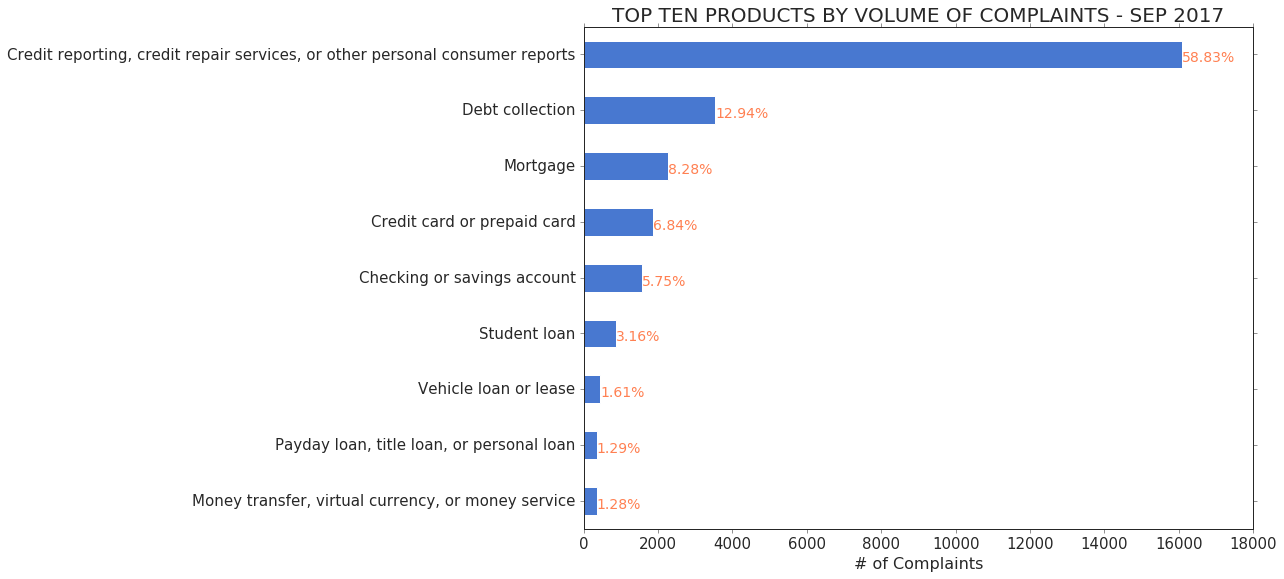

In [37]:
#In September 2017, what were the top five products and issues by volume of complaints? 

TopFiveProd = sqlContext.sql("SELECT Product, count(1) AS TotComplaints FROM ComplsInSep2017                          \
                             GROUP BY Product                                                                     \
                             ORDER BY count(1) DESC LIMIT 10")

plots = TopFiveProd.toPandas()

ax=plots.plot(kind='barh',
              x='Product',
              y='TotComplaints',
              legend=None)

plt.title('TOP TEN PRODUCTS BY VOLUME OF COMPLAINTS - SEP 2017', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 16)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total_Complaints_Sep2017)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()


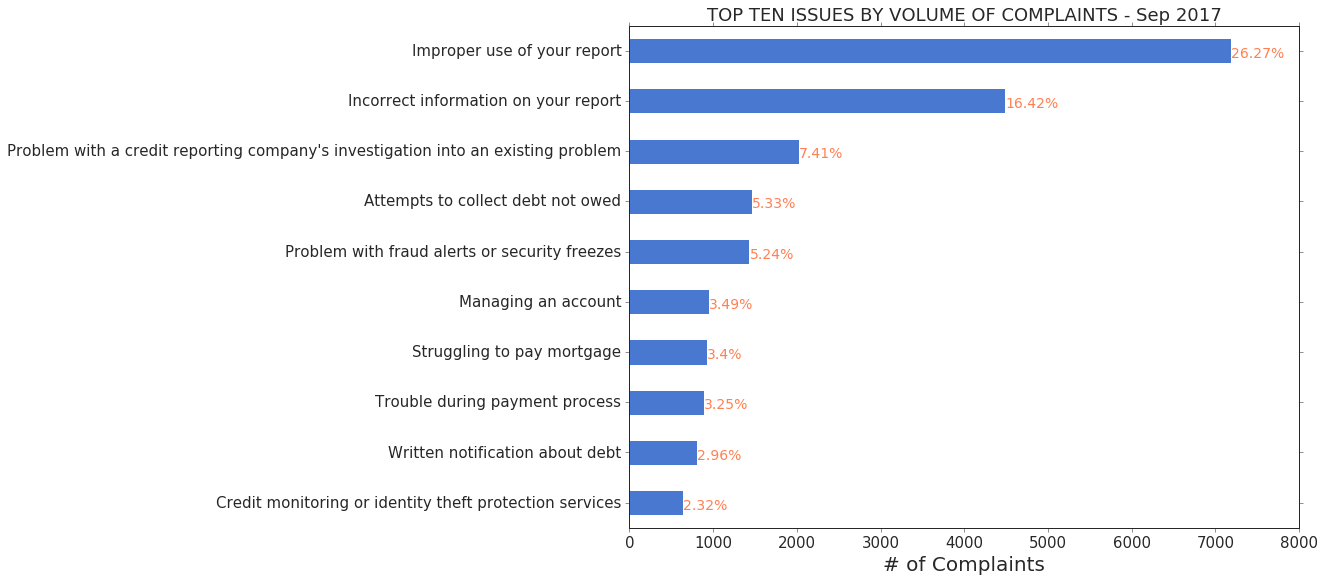

In [38]:
#In September 2017, what were the top five  issues ? 

TopFiveIssues = sqlContext.sql("SELECT Issue, count(1) AS TotComplaints FROM ComplsInSep2017                          \
                             GROUP BY Issue                                                                     \
                             ORDER BY count(1) DESC LIMIT 10")

plots = TopFiveIssues.toPandas()

ax=plots.plot(kind='barh',
              x='Issue',
              y='TotComplaints',
              legend=None)

plt.title('TOP TEN ISSUES BY VOLUME OF COMPLAINTS - Sep 2017', fontsize=18)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 20)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total_Complaints_Sep2017)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()


In [39]:
#What are the top ten states affected by the Equifax issue?

sqlContext.sql("SELECT State, count(1) AS TotComplaints FROM ComplsInSep2017   \
                            WHERE Company LIKE 'EQUIFAX%'   \
                            AND State <> ' '                \
                            GROUP BY State                  \
                            ORDER BY count(1) DESC").show(10)


+-----+-------------+
|State|TotComplaints|
+-----+-------------+
|   CA|         1791|
|   TX|          773|
|   NY|          578|
|   IL|          456|
|   GA|          399|
|   WA|          395|
|   FL|          385|
|   PA|          325|
|   NC|          309|
|   VA|          293|
+-----+-------------+
only showing top 10 rows



In [40]:
# Were all the complaints against Equifax closed by the company on time?

sqlContext.sql("SELECT Timely_Resp, count(1) AS TotComplaints FROM ComplsInSep2017   \
                            WHERE Company LIKE 'EQUIFAX%'   \
                            GROUP BY Timely_Resp").show(2)


+-----------+-------------+
|Timely_Resp|TotComplaints|
+-----------+-------------+
|         No|            1|
|        Yes|         9735|
+-----------+-------------+



In [41]:
#To how many of those consumers did they provide monetary relief?


sqlContext.sql("SELECT Comp_Resp_Cnsmr, count(1) AS Response FROM ComplsInSep2017                                                \
                      WHERE Company LIKE 'EQUIFAX%' GROUP BY Comp_Resp_Cnsmr ORDER BY Response").show()



+--------------------+--------+
|     Comp_Resp_Cnsmr|Response|
+--------------------+--------+
|Closed with monet...|       1|
|Closed with non-m...|     427|
|Closed with expla...|    9308|
+--------------------+--------+



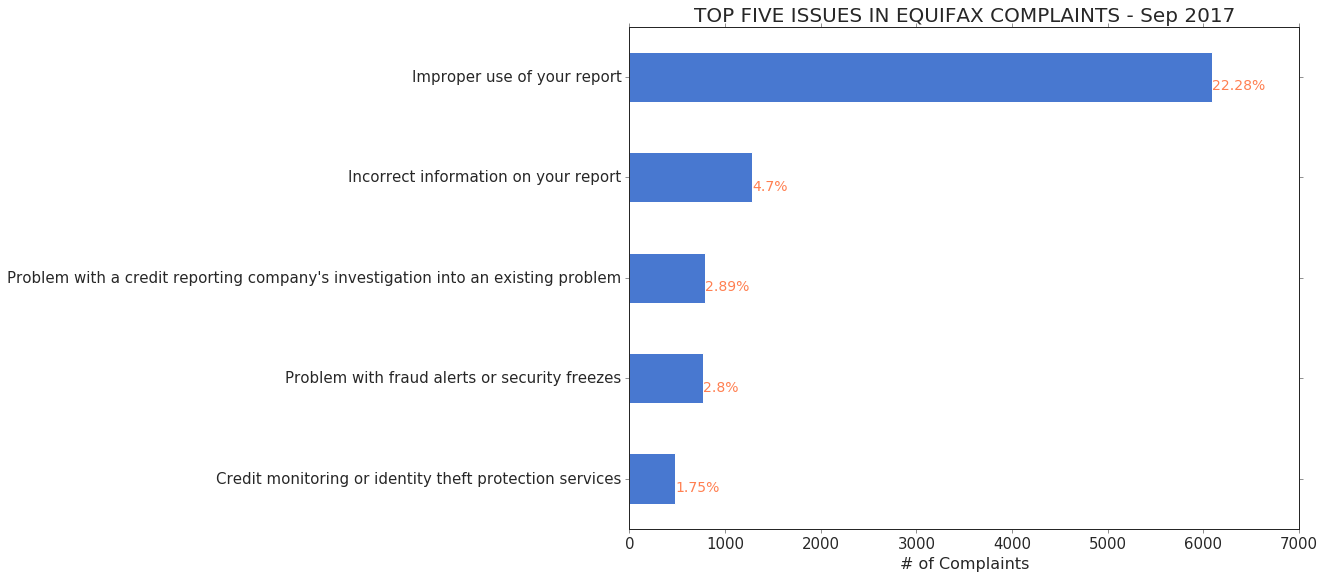

In [42]:
#What were the main issues raised against EquiFax ?

TopFiveIssues = sqlContext.sql("SELECT Issue, count(1) AS TotComplaints FROM ComplsInSep2017  \
                             WHERE Company LIKE 'EQUIFAX%'         \
                             GROUP BY Issue                                                                     \
                             ORDER BY count(1) DESC LIMIT 5")

plots = TopFiveIssues.toPandas()

ax=plots.plot(kind='barh',
              x='Issue',
              y='TotComplaints',
              legend=None)

plt.title('TOP FIVE ISSUES IN EQUIFAX COMPLAINTS - Sep 2017', fontsize=20)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 16)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total_Complaints_Sep2017)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()




In [43]:
# What is the total number of complaints against Transunion Intermediate Holding Inc Inc in September 2017?
TransUnion_SepCnt = sqlContext.sql("SELECT Company, count(1) AS TotComplaints_Sep2017 FROM ComplsInSep2017                  \
                            WHERE Company LIKE 'TRANSUNION INTERMEDIATE HOLDING%'               \
                            GROUP BY Company                                                    \
                            ORDER BY count(1) DESC LIMIT 5")
DF1 = TransUnion_SepCnt.toPandas()


# WHat is the total number of complaints against Transunion Intermediate Holding Inc in the database except for the month Sep 2017
TransUnion_AllExcpSepCnt = sqlContext.sql("SELECT Company, count(1) AS TotComplaints_ExcptSep2017 FROM Complaint_df                     \
                            WHERE Company LIKE 'TRANSUNION INTERMEDIATE HOLDING%'               \
                            AND year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)) <> 2017    \
                            AND month(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))  <> 9     \
                            GROUP BY Company                                                    \
                            ORDER BY count(1) DESC LIMIT 5")
DF2 = TransUnion_AllExcpSepCnt.toPandas()

# Count the number of year-month combinations in the consumer database
MMYY_Count = sqlContext.sql("SELECT distinct(year(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP)),   \
                       month(CAST(UNIX_TIMESTAMP(Complaint_df.Date_Rxd, 'MM/dd/yyyy') AS TIMESTAMP))) AS Instances           \
                       FROM Complaint_df ORDER BY Instances")
Count = MMYY_Count.count()


# WHat is the average number of complaints against Transunion Intermediate Holding Inc per month in the database
DF2['TotComplaints_Sep2017'] = DF1['TotComplaints_Sep2017']                                                                           
DF2['MonthAvg_ExclSep2017'] = DF2['TotComplaints_ExcptSep2017'] / (Count-1)  
DF2.head()

,Company,TotComplaints_ExcptSep2017,TotComplaints_Sep2017,MonthAvg_ExclSep2017
0,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",56211,2425,878.296875
